In [1]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
#Import stopwords
from nltk.corpus import stopwords

Let us start with a simplified corpus

In [2]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

Skip-Gram model tries to predict context given a word. So as input it expect word and as output words which often appears with the inputed one. We have implemented some suportive functions

In [9]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i+=1
    return vocabulary

def prepare_set(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Outputs columns for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input'] + [f'Output{i+1}' for i in range(n_gram*2)]
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out.append(sentence.split()[i-n])
                else:
                    out.append('<padding>')
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append('<padding>')
            row = pd.DataFrame([inp+out], columns = columns)
            #result = result.append(row, ignore_index = True)
            result = pd.concat([result, row], ignore_index=True)
    return result


In [20]:
def prepare_set_ravel(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    #result = result.append(row, ignore_index = True)
                    result = pd.concat([result, row], ignore_index=True)
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    #result = result.append(row, ignore_index = True)
                    result = pd.concat([result, row], ignore_index=True)
    return result

Do some preprocessing

In [21]:
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus


['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car']

Here we are creating a vocabulary which gives id for each word appearing in corpus.

In [22]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'berlin': 13,
 'germany': 14,
 'boston': 15,
 'usa': 16,
 'mercedes': 17,
 'car': 18,
 'ford': 19}

Below we can observe the logic. We are taking two neighbors from each side of center word. We can see many padding tokens, that is because maximal length of our sentences is 3, which is why each word will have at least two neighbors being padding. It's done just for presentation purposes. Below you can see some plots, which will help to understand the logic better.


<img src="image/skip-gram-image1.png" width="20%"/>

In [23]:
train_emb = prepare_set(corpus, n_gram = 2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<padding>,milk,<padding>,<padding>
1,milk,drink,<padding>,<padding>,<padding>
2,drink,<padding>,cold,<padding>,water
3,cold,drink,water,<padding>,<padding>
4,water,cold,<padding>,drink,<padding>


In [24]:
train_emb = prepare_set_ravel(corpus, n_gram = 2)
train_emb.head()

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink


In [25]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


We have one-hot encoded vector as input and one-hot encoded vector as output. Input and output vectors are equal
to length of the vocabolary. All elements are zero except the one which let us identofy which word
from the vocabolary is encoded.
In between input and output we choose length of a hidden layer. Length of hidden layer defines
dimension of the embedding vector. Mulitplying the on hot encoded vector with the weights will activate one row
of the weights matrix. One step of the neural network will optimize one row which corresponds
to the particular word from the vocabolary. This will allow us to use vectors from weight matrix as 
representation of words.

Let is define the loss function. We want to predict the context given a word. So we want to maximise the equation below:

$\max \prod_{\text {center }} \prod_{\text {context }} P($ context $\mid$ center $; \theta)$

It is easier to minimize with neural networks, hence lets convert it into a minimise equation:
    
$\min -\prod_{\text {center }} \prod_{\text {context }} P($ context $\mid$ center $; \theta)$

Adding logrithm before the equation will to use it's useful property, concretely:

$\min -\prod_{\text {center }} \prod_{\text {context }}\log P($ context $\mid$ center $; \theta)$

$\log (a * b)=\log (a)+\log (b)$

min $-\sum_{\text {center }} \sum_{\text {context }} \log P($ context $\mid$ center $; \theta)$

Lets define $P($ context $\mid$ center $; \theta)$ , softmax function will be used: 
    $P($ context $\mid$ center $)=\frac{\exp \left(u_{\text {context }}^T v_{\text {center }}\right)}{\sum_{\omega \in \text { vocab }} \exp \left(u_\omega^T v_{\text {center }}\right)}$
    
where $u_{\text {context }}^T v_{\text {center }}$ is a scalar product of vectors $u$ and $v$ (context, center respectively). Summarizing, the cost or loss function looks like this:

$\min -\sum_{\text {center }} \sum_{\text {context }} \log \frac{\exp \left(u_{\text {context }}^T v_{\text {center }}\right)}{\sum_{\omega \in \text { vocab }} \exp \left(u_\omega^T v_{\text {center }}\right)}$

In [27]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encoded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

# Using embedding size of 5

embedding_dims = 5
device = torch.device('cpu')

Next, weight initialization. Look above on the architecture of NN. W1 matrix of size `vocab_size  ×
  embedding_dims`, W2 of shape `embedding_dims × vocab_size`. Pay attention we put requires_grad as True, because we want NN to compute gradients for those weights matices for their optimization. Function torch.randn randomly initialize weights. But very important to initialize weights correctly. What does it mean? Weights should be initialized to small random numbers. If you are not careful enough with this step, model can generate unexpected and not useful results. For this uniform function is used here, it limits bounds of weights to  (−0.5/
 embedding_dims,  0.5/
 embedding_dims).

In [28]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) # shape V*H
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) #shape H*V
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')

W1 shape is: torch.Size([20, 5]), W2 shape is: torch.Size([5, 20])


In [29]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

Here we use DataLoader from PyTorch, it loads data by batches. That iss very useful tool, if you are not familiar 
with it I encourage you to have a look to avoid unnecessary coding. Our dataset is very small, so we don't need 
DataLoader here, it's added just for learning, that's why batch_size equals the dataset's number of rows. 
we will use the whole dataset for one iteration, here one iteration == one epoch. Pay attention, that 
get_input_tensor function defined above is used only for input layer, that's because CrossEntropyLoss expect true 
outputs as vector in long format, provided by DataLoader.



In [30]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # see details: https://pytorch.org/docs/stable/nn.html
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        
        # Update weights using gradient descent. For this step we just want to mutate
        # the values of w1 and w2 in-place; we don't want to build up a computational
        # graph for the update steps, so we use the torch.no_grad() context manager
        # to prevent PyTorch from building a computational graph for the updates
        with torch.no_grad():
            # SGD optimization is implemented in PyTorch, but it's very easy to implement manually providing better understanding of process
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')
    

Epoch 0, loss = 2.998577833175659
Epoch 50, loss = 2.625443696975708
Epoch 100, loss = 1.2810331583023071
Epoch 150, loss = 1.0042035579681396
Epoch 200, loss = 0.9315589070320129
Epoch 250, loss = 1.0800772905349731
Epoch 300, loss = 1.3391231298446655
Epoch 350, loss = 1.0540748834609985
Epoch 400, loss = 1.5374940633773804
Epoch 450, loss = 1.3225044012069702
Epoch 500, loss = 1.1197007894515991
Epoch 550, loss = 1.1503740549087524
Epoch 600, loss = 1.3379549980163574
Epoch 650, loss = 1.3130196332931519
Epoch 700, loss = 1.4010224342346191
Epoch 750, loss = 1.1631858348846436
Epoch 800, loss = 1.1985926628112793
Epoch 850, loss = 1.2639422416687012
Epoch 900, loss = 1.1020801067352295
Epoch 950, loss = 1.062979817390442
Epoch 1000, loss = 1.0206540822982788
Epoch 1050, loss = 1.003631830215454
Epoch 1100, loss = 0.9823724627494812
Epoch 1150, loss = 0.9604396820068359
Epoch 1200, loss = 0.9419291615486145
Epoch 1250, loss = 0.9268764853477478
Epoch 1300, loss = 0.920346200466156
Ep

In [31]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

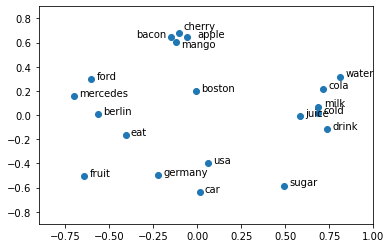

In [74]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]

import matplotlib.pyplot as plt
#plot = plt.scatter(x, y)
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_ylim(-0.9, 0.9)
ax.set_xlim(-0.9, 1.0)
for i, txt in enumerate(W1_dec):
    #print(list(vocabulary.keys())[i])
    label = list(vocabulary.keys())[i]

    if label == 'cherry':
        _y = y[i]+ 0.03
        #print('inside')
    elif label == 'mango':
        _y = y[i] - 0.04
    else:
        _y = y[i]
    if label == 'apple':
        _x = x[i] + 0.06
    elif label == 'bacon':
        _x = x[i] - 0.2
    else:
        _x = x[i]+ 0.03

    ax.annotate(list(vocabulary.keys())[i], (_x, _y))
    